In [4]:
import sys
sys.path.append('../')

import tquant as tq
from datetime import date

# from datastore import *
import matplotlib.pyplot as plt
import QuantLib as ql
import pandas as pd

def get_ql_curve(curve_tq, evaluation_date):
    evaluation_date_ql = ql.Date.from_date(evaluation_date)
    dates_ql = [evaluation_date_ql + d for d in curve_tq._pillar_days]
    rates_ql = [r.numpy() for r in curve_tq._rates]
    curve_ql = ql.ZeroCurve(dates_ql, rates_ql, ql.ActualActual(ql.ActualActual.ISDA), ql.TARGET())
    curve_ql.enableExtrapolation()
    return curve_ql

curve_map = {
    "EUR": {
        "ON": "EUR:ESTR",
        "3M": "EUR:3M",
        "6M": "EUR:6M"
    },
    "USD": {
        "ON": "USD:SOFR",
        "3M": "USD:3M",
        "6M": "USD:6M"
    }
}


# Settings

In [5]:
tq.Settings.evaluation_date = date(2024, 7, 31)

calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date

# Market

In [6]:
mkt = pd.read_excel("market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates_estr = estr_df['quote'].values/100
times_estr = [daycounter.day_count(evaluation_date, d) for d in estr_df['end']]

rates_6m = eur6m_df['quote'].values/100
times_6m = [daycounter.day_count(evaluation_date, d) for d in eur6m_df['end']]

market_data = {}
market_data["EUR:ESTR"] = tq.RateCurve(reference_date=evaluation_date,
                                        pillars=estr_df['end'],
                                        rates=rates_estr,
                                        interp='LINEAR',
                                        daycounter_convention=tq.DayCounterConvention.ActualActual)
market_data["EUR:6M"] = tq.RateCurve(reference_date=evaluation_date,
                                        pillars=eur6m_df['end'],
                                        rates=rates_6m,
                                        interp='LINEAR',
                                        daycounter_convention=tq.DayCounterConvention.ActualActual)
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR)

In [7]:
curve_map

{'EUR': {'ON': 'EUR:ESTR', '3M': 'EUR:3M', '6M': 'EUR:6M'},
 'USD': {'ON': 'USD:SOFR', '3M': 'USD:3M', '6M': 'USD:6M'}}

# Deposit

In [8]:
spot_date = calendar.advance(evaluation_date, 2, tq.TimeUnit.Days, tq.DayCounterConvention.Actual360)
maturity = calendar.advance(spot_date, 1, tq.TimeUnit.Days, tq.DayCounterConvention.Actual360)
quote = 0.03

deposit = tq.Deposit(ccy=tq.Currency.EUR,
                    quote=quote,
                    trade_date=evaluation_date,
                    start_date=spot_date,
                    end_date=maturity,
                    notional=100,
                    day_count_convention=tq.DayCounterConvention.Actual360)
depo_engine = tq.DepositPricer(curve_map)
npv_depo, tape = depo_engine.price(deposit, evaluation_date, market_data, True)
sensy_depo = tape.gradient(npv_depo, market_data["EUR:ESTR"]._rates)

# results
sensy_depo = pd.DataFrame([market_data["EUR:ESTR"]._pillars, sensy_depo]).T
sensy_depo.columns = ['time', 'sensy']
sensy_depo.fillna(0, inplace = True)
sensy_depo.set_index('time', inplace = True)
sensy_depo['sensy'] = sensy_depo['sensy'].apply(tq.extract_value)
sensy_depo[sensy_depo['sensy'] != 0]


,sensy
time,
0.005464,-0.546835
0.013661,1.363827
0.024590,0.004690


# Forward Rate Agreement

In [9]:
notional=100e6
fixed_rate = 0.03

eur_fra_builder = tq.FraGenerator(ccy=tq.Currency.EUR,
                                  start_delay=2,
                                  fixing_days=2,
                                  index_term="6M",
                                  roll_convention= tq.BusinessDayConvention.ModifiedFollowing,
                                  notional=notional,
                                  day_count_convention=tq.DayCounterConvention.Actual360,
                                  calendar=calendar,
                                  index=eur6m_index)  
fra = eur_fra_builder.build(trade_date=evaluation_date, quote=fixed_rate, term="3M-9M")

In [10]:
fra_engine = tq.FraPricer(curve_map)
npv_fra, tape = fra_engine.price(fra, evaluation_date, market_data, True)
print(f"NPV FRA: {npv_fra :,.0f}")

NPV FRA: -33,973


## Debug vs quantlib

In [11]:
ql.Settings.instance().evaluationDate = ql.Date.from_date(evaluation_date)
estr_ql = get_ql_curve(market_data['EUR:ESTR'], evaluation_date)
eur6m_ql = get_ql_curve(market_data['EUR:6M'], evaluation_date)
handleYieldTermStructure_estr = ql.YieldTermStructureHandle(eur6m_ql)
handleYieldTermStructure = ql.YieldTermStructureHandle(eur6m_ql)
index_ql = ql.Euribor6M(handleYieldTermStructure)
calendar_ql = ql.TARGET()

start_date_ql = ql.Date.from_date(fra.start_date) 
end_date_ql = ql.Date.from_date(fra.maturity)

fra_ql = ql.ForwardRateAgreement(start_date_ql, end_date_ql, ql.Position.Long, fixed_rate, notional, index_ql, handleYieldTermStructure_estr)

print(f"NPV FRA TQ: {npv_fra :,.0f}")
print(f"NPV FRA QL: {fra_ql.NPV() :,.0f}")

# cambia il forward leggermente rispetto a ql, da utilizzare il daycounter act/360 dell'indice eur6m

NPV FRA TQ: -33,973
NPV FRA QL: -53,558


In [12]:
tau = fra.day_counter.year_fraction(fra.start_date, fra.end_date) #da vedere funzione QL originale
fwd = handleYieldTermStructure_estr.forwardRate(start_date_ql, end_date_ql, ql.Actual360(), ql.Simple).rate()
# fwd = fra_ql.forwardRate().rate()
# fwd = market_data['EUR:6M'].forward_rate(fra.start_date, fra.end_date).numpy()

amount_ql = ((fwd - fixed_rate) * notional * tau ) / (1 + fwd*tau) #*discount
#fra_ql.amount()

In [13]:
fra_ql.amount()

-54056.35341364953

# OIS

## tQuant

In [14]:
estr_index = tq.OvernightIndex(calendar, tq.Currency.EUR)

eur_ois_builder = tq.OisGenerator(
                        ccy=tq.Currency.EUR,
                        start_delay=2,
                        fixing_days=2,
                        period_fix="1Y",
                        period_flt="1Y",
                        roll_convention= tq.BusinessDayConvention.ModifiedFollowing,
                        notional=100e6,
                        day_count_convention_fix= tq.DayCounterConvention.Actual360,
                        day_count_convention_flt= tq.DayCounterConvention.Actual360,
                        calendar=calendar,
                        index= estr_index)

fixed_rate = 0.01
ois = eur_ois_builder.build(trade_date=evaluation_date, quote=fixed_rate, term="5Y")

In [15]:
ois_engine = tq.OisPricer(curve_map)
npv_ois, tape = ois_engine.price(ois, evaluation_date, market_data, True)
sensitivities = tape.gradient(npv_ois, [market_data['EUR:ESTR']._rates, market_data['EUR:6M']._rates])

print(f"NPV FixedLeg: {ois_engine.pv_fix :,.0f}")
print(f"NPV FloatingLeg: {ois_engine.pv_flt :,.0f}")
########
print(f"NPV OIS: {npv_ois :,.0f}")

NPV FixedLeg: 4,703,160
NPV FloatingLeg: 11,375,789
NPV OIS: 6,672,629


## Debug vs QuantLib

In [16]:
ql.Settings.instance().evaluationDate = ql.Date.from_date(evaluation_date)
estr_ql = get_ql_curve(market_data['EUR:ESTR'], evaluation_date)
handleYieldTermStructure = ql.YieldTermStructureHandle(estr_ql)

swapType = ql.OvernightIndexedSwap.Payer
nominal = 100e6
schedule = ql.MakeSchedule(ql.Date.from_date(ois.start_date), ql.Date.from_date(ois.maturity), ql.Period('1Y'), calendar=ql.TARGET())
fixedRate = 0.01
fixedDC = ql.Actual360()
overnightIndex = ql.Estr(handleYieldTermStructure)
ois_swap = ql.OvernightIndexedSwap(swapType, nominal, schedule, fixedRate, fixedDC, overnightIndex)

engine = ql.DiscountingSwapEngine(handleYieldTermStructure)
ois_swap.setPricingEngine(engine)
print(f"NPV QL Swap: {ois_swap.NPV() :,.0f}")
print(f"NPV TQ Swap: {npv_ois :,.0f}")

NPV QL Swap: 6,517,698
NPV TQ Swap: 6,672,629


# Vanilla Swap

## tQuant

In [17]:
currency = tq.Currency.EUR
mod_fol_convention = tq.BusinessDayConvention.ModifiedFollowing
daycount_fix = tq.DayCounterConvention.Actual360
daycount_flt = tq.DayCounterConvention.Actual360

settlement_delay = 2 
period_fixed_leg = "1Y"
period_float_leg = "6M"

irs_eur6m_generator = tq.SwapGenerator(currency, settlement_delay, period_fixed_leg, period_float_leg, mod_fol_convention, 100e6, daycount_fix, daycount_flt, calendar, eur6m_index)
fixed_rate = 0.01
swap = irs_eur6m_generator.build(trade_date=evaluation_date, quote=0.01, term="10Y")

In [18]:
swap_engine = tq.SwapPricer(curve_map)
npv_swap, tape = swap_engine.price(swap, evaluation_date, market_data, True)
sensitivities = tape.gradient(npv_swap, [market_data['EUR:ESTR']._rates, market_data['EUR:6M']._rates])

print(f"NPV FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV FloatingLeg: {swap_engine.pv_flt :,.0f}")
########
print(f"NPV Swap: {npv_swap :,.0f}")

NPV FixedLeg: 8,878,357
NPV FloatingLeg: 23,300,635
NPV Swap: 14,422,278


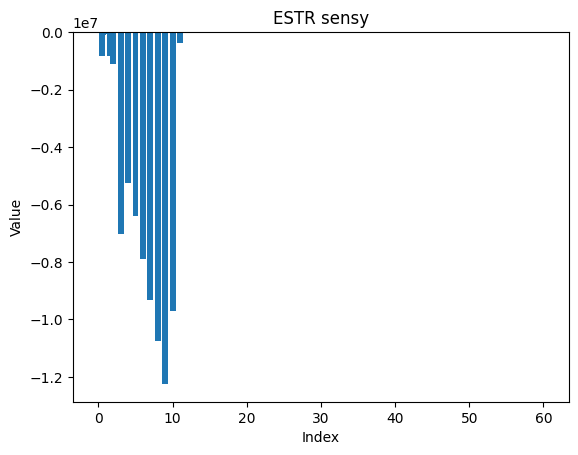

In [21]:
sensy_estr = pd.DataFrame([market_data['EUR:ESTR']._pillars, sensitivities[0]]).T
sensy_estr.columns = ['time', 'sensy_estr']
sensy_estr.fillna(0, inplace = True)
sensy_estr.set_index('time', inplace = True)
sensy_estr['sensy_estr'] = sensy_estr['sensy_estr'].apply(tq.extract_value)

sensy_eur6m = pd.DataFrame([market_data['EUR:6M']._pillars, sensitivities[1]]).T
sensy_eur6m.columns = ['time', 'sensy_eur6m']
sensy_eur6m.fillna(0, inplace = True)
sensy_eur6m.set_index('time', inplace = True)
sensy_eur6m['sensy_eur6m'] = sensy_eur6m['sensy_eur6m'].apply(tq.extract_value)

plt.bar(sensy_estr.index, sensy_estr['sensy_estr'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('ESTR sensy')
plt.show()

## Debug vs QuantLib

In [22]:

def makeVanillaSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    end = maturity# ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("12M")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap

In [23]:
ql.Settings.instance().evaluationDate = ql.Date.from_date(evaluation_date)
estr_ql = get_ql_curve(market_data['EUR:ESTR'], evaluation_date)
eur6m_ql = get_ql_curve(market_data['EUR:6M'], evaluation_date)
handleYieldTermStructure = ql.YieldTermStructureHandle(eur6m_ql)
index_ql = ql.Euribor6M(handleYieldTermStructure)
calendar_ql = ql.TARGET()

In [24]:
start_date_ql = ql.Date.from_date(swap.start_date) +2
end_date_ql = ql.Date.from_date(swap.maturity)
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)

swap_ql2 = makeVanillaSwap(start_date_ql, end_date_ql, swap.notional, swap.quote, index_ql )
swap_ql2.setPricingEngine(engine)
print(f"NPV QL Swap: {swap_ql2.NPV() :,.0f}")
print(f"NPV TQ Swap: {npv_swap :,.0f}")
print(20*"*")
print(f"NPV QL FixedLeg: {swap_ql2.fixedLegNPV() :,.0f}")
print(f"NPV TQ FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV QL FloatingLeg: {swap_ql2.floatingLegNPV() :,.0f}")
print(f"NPV TQ FloatingLeg: {swap_engine.pv_flt :,.0f}")

NPV QL Swap: 14,128,229
NPV TQ Swap: 14,422,278
********************
NPV QL FixedLeg: -8,693,942
NPV TQ FixedLeg: 8,878,357
NPV QL FloatingLeg: 22,822,171
NPV TQ FloatingLeg: 23,300,635
